# Segmentation based on Thresholding

## Import Packages

In [1]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
%matplotlib inline

## Functions for Loading Dicom

In [2]:
# Loading the dicom images and storing into a list

def load_scan(path):
    patients = os.listdir(path)
    patients.sort()

    while patients[0][0] == '.':
        del patients[0]
    
    slices = [dicom.read_file(path + '/' + s, force=True) for s in patients]
    
    return slices

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
        
    # Convert to int16-> it should be possible because 
    # values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024. so air is approximately 0
    # Some scanners have cylindrical scanning bounds, but the output image is square. 
    # The pixels that fall outside of these bounds get the fixed value -2000. 
    # The first step is setting these values to 0, which currently corresponds to air. 
    # Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept 
    # which are conveniently stored in the metadata of the scans
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    intercept = slices[0].RescaleIntercept
    slope     = slices[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image    += np.int16(intercept)

    return np.array(image, dtype = np.int16)

## Displaying Dicom images

In [4]:
# Load data
data_path    = "data/input/COD0005/"
output_path  = "data/output/"
working_path = "data/output/"
g            = glob(data_path + '/*')

# If some cases as above, the images do not have .dcm 
# In case your image have it, uncomment the next line:
#g           = glob(data_path + '/*.dcm')

# Print out the first files names
print("Total of %d Dicom images: " %len(g))
print("First five filenames: ")
print("\n".join(g[:5]))


Total of 280 Dicom images: 
First five filenames: 
data/input/COD0005/I195
data/input/COD0005/I43
data/input/COD0005/I248
data/input/COD0005/I141
data/input/COD0005/I23


280
(280, 512, 512)


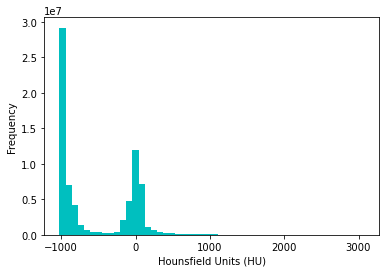

In [5]:
# Save the new data set to disk so that
# we do not reprocess the stack every time
id      = 0
patient = load_scan(data_path)
print (len(patient))
imgs    = get_pixels_hu(patient)
print(imgs.shape)
np.save(output_path + "images_%d.npy" %(id), imgs)

# Create a histogram of all the voxel data 
file_data      = output_path + "images_%d.npy"%id
img_to_process = np.load(file_data).astype(np.float64)

plt.hist(img_to_process.flatten(), bins = 50, color = 'c')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.show()

## Displaying an Image Stack

(280, 512, 512)


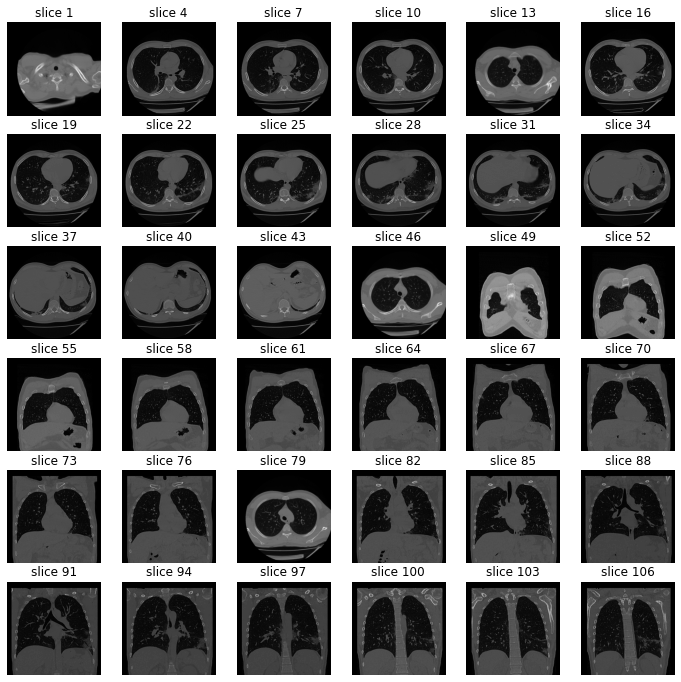

In [6]:
id = 3
img_to_process = np.load(output_path + "images_{}.npy".format(id))
print(img_to_process.shape)

def sample_stack(stack, rows = 6, cols = 6, start_with = 1, show_every = 3):
    fig, ax = plt.subplots(rows, cols, figsize = [12, 12])

    for i in range(rows * cols):
        idx = start_with + i * show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % idx)
        ax[int(i/rows),int(i % rows)].imshow(stack[idx],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    
    plt.show()

sample_stack(img_to_process)

## Resampling

In [7]:
print ("Slice Thickness: %f" %patient[0].SliceThickness)
print ("Pixel Spacing (row, col) : (%f, %f)" % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))


Slice Thickness: 3.750000
Pixel Spacing (row, col) : (0.722500, 0.722500)


In [8]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    print(scan[0].PixelSpacing)
    #spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)]
    space = []
    space.append(scan[0].SliceThickness)
    space.append(scan[0].PixelSpacing[0])
    space.append(scan[0].PixelSpacing[1])
    spacing = np.array(space, dtype=np.float32)
    print(spacing)
    spacing = np.array(list(spacing))

    resize_factor      = spacing  / new_spacing
    print(resize_factor)
    new_real_shape     = image.shape * resize_factor
    new_shape          = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing        = spacing   / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [9]:
id = 0
imgs_to_process = np.load(output_path+'images_{}.npy'.format(id))
print ("Shape before resampling\t", imgs_to_process.shape)
print(len(patient))
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (280, 512, 512)
280
[0.7224999666, 0.7224999666]
[3.75       0.72249997 0.72249997]
[3.75       0.72249997 0.72249997]
Shape after resampling	 (1050, 370, 370)


## 3D Plotting the scan

In [10]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright
    p            = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig          = plt.figure(figsize=(10, 10))
    ax           = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh         = Poly3DCollection(verts[faces], alpha=0.70)
    face_color   = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


In [11]:
#plot_3d(imgs_after_resamp, 400)

## Traditional Segmentation

In [12]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size = img.shape[0]
    col_size = img.shape[1]
    
    mean     = np.mean(img)
    std      = np.std(img)
    img      = img-mean
    img      = img/std

    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle  = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean    = np.mean(middle)  
    max     = np.max(img)
    min     = np.min(img)

    # To improve threshold finding:
    # move the underflow and overflow on the pixel spectrum
    img[img==max] = mean
    img[img==min] = mean

    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)

    kmeans      = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers     = sorted(kmeans.cluster_centers_.flatten())
    threshold   = np.mean(centers)
    thresh_img  = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, 
    # then dilate to include some of the pixels surrounding the lung.  

    eroded      = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation    = morphology.dilation(eroded,np.ones([8,8]))

    labels      = measure.label(dilation) # Different labels are displayed in different colors
    regions     = measure.regionprops(labels)
    good_labels = []


    for prop in regions:
        B       = prop.bbox

        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask       = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:]    = 0

    
    #  After just the lungs are left, another large dilation is performed
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask   = mask + np.where(labels==N,1,0)
    mask       = morphology.dilation(mask,np.ones([10,10])) 

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

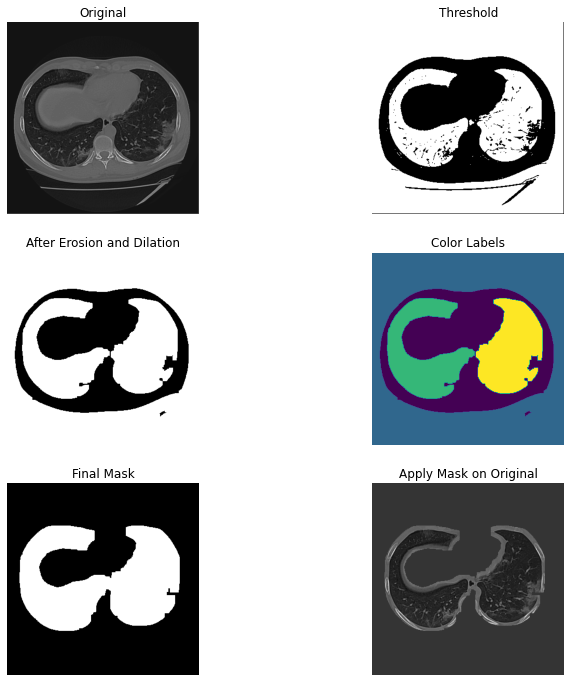

array([[-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0., -0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [13]:
img = imgs_after_resamp[100]
make_lungmask(img, display=True)

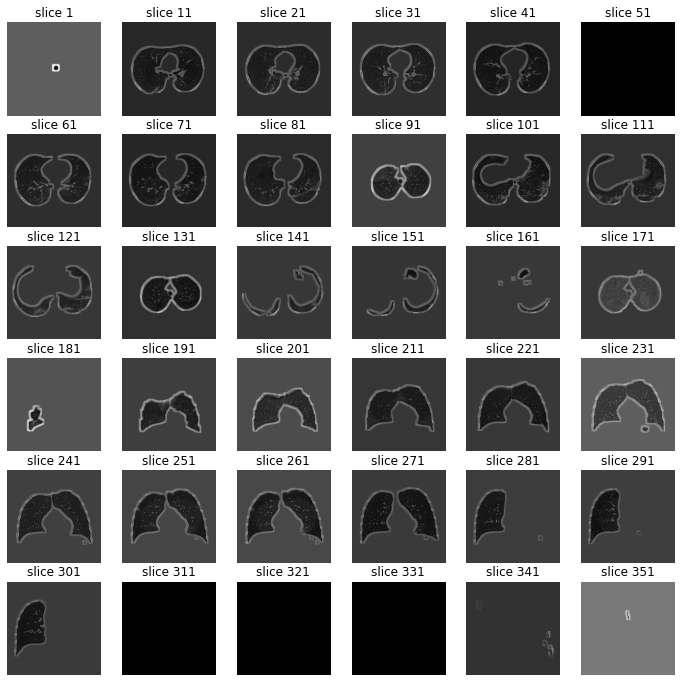

In [14]:
# Apply masks to all slices
masked_lung = []

for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=10)

In [15]:
# Save masks
np.save(output_path + "maskedimages_%d.npy" % (id), imgs)